In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/harvard.dce.nasa.cloud2cloud

Mounted at /content/drive
/content/drive/MyDrive/harvard.dce.nasa.cloud2cloud


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import os
import io
import cv2
import shutil
import datetime

In [3]:
def extract_cloud_top(all_layers):
    """
    Extract cloud top height using discriminator.
    Args:
        all_layers (str): string containing tuple like data for all layers.
    Returns:
        (int, int, int): top_height, bottom_height, discriminator
    """
    layers = all_layers.split(')(')
    for layer in layers:
        layer = layer.strip('() ')
        parts = layer.split()
        if len(parts) == 3:
            top_height, bottom_height, discriminator = map(int, parts)
            if discriminator == 3:
                return top_height, bottom_height, 3
    return None, None, None


def prepare_lidar_data(file_path):
    """
    Prepare lidar dataframe from text file.
    Extract key features with timstamp, angle and top height in the layer where clouds first occur.
    Args:
        file_path (str): fully qualified file path.
    Returns:
        (pd.DataFrame): lidar dataframe with the required columns
    """
    file_date = file_path.split('_')[-1]
    formatted_date = f"{file_date[:4]}-{file_date[4:6]}-{file_date[6:8]}"
    data = []
    with open(file_path, 'r') as file:
        for _ in range(13):
            next(file)

        for line in file:
            parts = line.strip().split(maxsplit=7)
            if len(parts) < 8:
                continue

            time, lat, lon, alt, angle, n, gh, all_layers = parts
            top_height, bottom_height, discriminator = extract_cloud_top(all_layers)

            if discriminator == 3:
                data.append([formatted_date, time, lat, lon, alt, angle, n, gh, top_height, bottom_height, discriminator])

    df = pd.DataFrame(data, columns=['date', 'timestamp', 'lat', 'lon', 'alt', 'angle', 'N', 'GH', 'top_height', 'bottom_height', 'layer_discriminator'])
    df['angle'] = df['angle'].astype(float)
    return df


def drop_large_turns(df, n):
    """
    Filters the DataFrame based on changes in the angle that exceed n degrees.

    Args:
    df (pd.DataFrame): Input DataFrame with a column 'Angle'.
    n (float): Threshold for change in angle to filter the DataFrame.

    Returns:
    tuple: A tuple containing the filtered DataFrame and the number of records dropped.
    """
    df['angle_lag'] = df['angle'].shift(1)
    df['angle_diff_to_prev'] = df['angle'] - df['angle_lag']

    initial_count = len(df)
    df_filtered = df[abs(df['angle_diff_to_prev']) <= n]
    df_dropped = df[abs(df['angle_diff_to_prev']) > n]

    df_filtered = df_filtered.drop(columns=['angle_lag'])

    return df_filtered, df_dropped


def filter_by_datetime(df, date, start_time, end_time):
    """
    Filters the DataFrame for records within a specified date and time range.

    Args:
    df (pd.DataFrame): The input DataFrame.
    date (str): The date as 'YYYY-MM-DD'.
    start_time (str): The start time as 'HH:MM:SS'.
    end_time (str): The end time as 'HH:MM:SS'.

    Returns:
    pd.DataFrame: A filtered DataFrame containing only records within the specified date and time range.
    """
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['timestamp'])

    start_datetime = pd.to_datetime(date + ' ' + start_time)
    end_datetime = pd.to_datetime(date + ' ' + end_time)

    filtered_df = df[(df['datetime'] >= start_datetime) & (df['datetime'] <= end_datetime)]
    filtered_df = filtered_df.drop(columns=['datetime'])

    return filtered_df


def plot_time_series(df, x, y1, y2=None):
    """
    Plots a time series from the DataFrame with one or two y variables.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    x (str): Column name for the time data, should be in datetime format.
    y1 (str): Column name for the primary variable to be plotted on the y-axis.
    y2 (str, optional): Optional column name for a secondary variable to be plotted on a secondary y-axis.
    """
    fig, ax1 = plt.subplots(figsize=(8, 8))

    color = 'tab:blue'
    ax1.set_xlabel('Time (HH:MM)')
    ax1.set_ylabel(y1, color=color)
    ax1.plot(df[x], df[y1], color=color, marker='o', linestyle='-', label=y1)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.set_title(f'Time Series Plot of {y1}' + (f' and {y2}' if y2 else ''))

    if y2:
        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel(y2, color=color)
        ax2.plot(df[x], df[y2], color=color, marker='o', linestyle='-', label=y2)
        ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()


def process_lidar_files(folder):
    """
    Write a function to process all files in the input folder.
    Iterate over all files in the folder
    For each file read it into a df
    Run prepare_lidar_data and drop_large_turns functions over the df
    and write back the df in a text file.
    Keep the name same as the input file but suffix it with processed.
    Args:
        folder (str): fully qualified folder path.
    Returns:
        (str): fully qualified output file path.
    """
    output_folder = folder + '_processed'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(folder):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder, filename)
            df = prepare_lidar_data(file_path)

            df_filtered, df_dropped = drop_large_turns(df, 10)

            output_file_path = os.path.join(output_folder, filename.replace('.txt', '_processed.txt'))

            df_filtered.to_csv(output_file_path, index=False)
            df_dropped.to_csv(output_file_path.replace('.txt', '_dropped.txt'), index=False)

    return output_folder

In [ ]:
output_folder = process_lidar_files("lidar")

In [ ]:
file_path = 'lidar/goesrplt_CPL_layers_17933_20170508.txt'
df = prepare_lidar_data(file_path)
print(df.shape)
df.head(10)

(2793, 11)


,date,timestamp,lat,lon,alt,angle,N,GH,top_height,bottom_height,layer_discriminator
0,2017-05-08,19:34:26,33.6905,-86.6977,18017,0.74,2,300,2368,2189,3
1,2017-05-08,19:37:01,33.8165,-86.9974,18227,0.97,2,150,2428,2069,3
2,2017-05-08,19:44:21,34.1694,-87.8500,18797,1.06,3,240,4887,4197,3
3,2017-05-08,19:44:26,34.1734,-87.8598,18797,1.17,2,240,4437,4257,3
4,2017-05-08,19:44:31,34.1774,-87.8696,18827,1.21,2,240,4947,4407,3
5,2017-05-08,19:45:11,34.2094,-87.9481,18857,1.09,2,240,5037,3837,3
6,2017-05-08,19:45:41,34.2333,-88.0069,18857,1.05,3,210,4887,4017,3
7,2017-05-08,19:46:41,34.2812,-88.1248,18887,1.13,3,180,510,240,3
8,2017-05-08,19:47:56,34.3412,-88.2732,18917,0.87,1,180,4977,4347,3
9,2017-05-08,19:48:01,34.3452,-88.2831,18917,0.94,3,150,5067,3688,3


In [ ]:
df.tail(10)

,date,timestamp,lat,lon,alt,angle,N,GH,top_height,bottom_height,layer_discriminator
2783,2017-05-08,01:25:24,38.8489,-99.2798,20806,1.90,1,600,12142,11812,3
2784,2017-05-08,01:25:29,38.8447,-99.2695,20806,1.66,1,600,12112,11812,3
2785,2017-05-08,01:25:34,38.8406,-99.2591,20806,1.35,1,600,12142,11842,3
2786,2017-05-08,01:25:39,38.8365,-99.2486,20806,1.18,1,600,12142,11842,3
2787,2017-05-08,01:25:44,38.8324,-99.2382,20806,1.00,1,630,12112,11842,3
2788,2017-05-08,01:25:49,38.8283,-99.2277,20806,0.98,1,630,12022,11842,3
2789,2017-05-08,01:25:54,38.8242,-99.2172,20806,1.07,2,630,12022,4257,3
2790,2017-05-08,01:25:59,38.8202,-99.2066,20806,1.24,1,630,11992,11842,3
2791,2017-05-08,01:26:44,38.7837,-99.1119,20806,1.01,1,570,5546,5456,3
2792,2017-05-08,01:26:54,38.7756,-99.0909,20806,0.96,1,600,5546,5426,3


In [ ]:
df_sample = filter_by_datetime(df, '2017-05-08', '20:28:28', '01:41:03')
print(df_sample.shape)
df_sample.head()

(435, 11)


,date,timestamp,lat,lon,alt,angle,N,GH,top_height,bottom_height,layer_discriminator
2139,2017-05-12,16:41:04,28.9522,-91.0498,19816,0.33,1,-999,12082,10673,3
2140,2017-05-12,16:41:09,28.9588,-91.0424,19816,0.38,1,-999,11992,10673,3
2141,2017-05-12,16:41:14,28.9654,-91.0350,19816,0.44,1,-999,11992,10703,3
2142,2017-05-12,16:41:19,28.9720,-91.0275,19816,0.41,1,-999,11902,10613,3
2143,2017-05-12,16:41:24,28.9786,-91.0200,19816,0.43,1,-999,11812,10733,3


In [ ]:
df.shape

(4782, 12)

In [ ]:
df_filtered, df_dropped = drop_large_turns(df_sample, 10)
print(df_filtered.shape)
df_filtered.head()

(423, 12)


,date,timestamp,lat,lon,alt,angle,N,GH,top_height,bottom_height,layer_discriminator,angle_diff_to_prev
2140,2017-05-12,16:41:09,28.9588,-91.0424,19816,0.38,1,-999,11992,10673,3,0.05
2141,2017-05-12,16:41:14,28.9654,-91.0350,19816,0.44,1,-999,11992,10703,3,0.06
2142,2017-05-12,16:41:19,28.9720,-91.0275,19816,0.41,1,-999,11902,10613,3,-0.03
2143,2017-05-12,16:41:24,28.9786,-91.0200,19816,0.43,1,-999,11812,10733,3,0.02
2144,2017-05-12,16:41:29,28.9852,-91.0125,19816,0.36,1,-999,11662,10703,3,-0.07


In [ ]:
print(df_dropped.shape)
df_dropped.head()

(11, 13)


,date,timestamp,lat,lon,alt,angle,N,GH,top_height,bottom_height,layer_discriminator,angle_lag,angle_diff_to_prev
2251,2017-05-12,16:50:24,29.6870,-90.2078,19786,11.60,1,-999,13041,12292,3,0.83,10.77
2376,2017-05-12,17:00:49,30.4291,-89.2188,19786,19.14,2,-999,13371,12801,3,8.64,10.50
2412,2017-05-12,17:03:49,30.5541,-89.4165,19816,9.35,1,-999,13521,12472,3,20.99,-11.64
2415,2017-05-12,17:04:04,30.5327,-89.4380,19816,16.59,1,-999,13191,12052,3,2.52,14.07
2417,2017-05-12,17:04:14,30.5175,-89.4509,19786,0.66,1,-999,13431,12352,3,15.14,-14.48


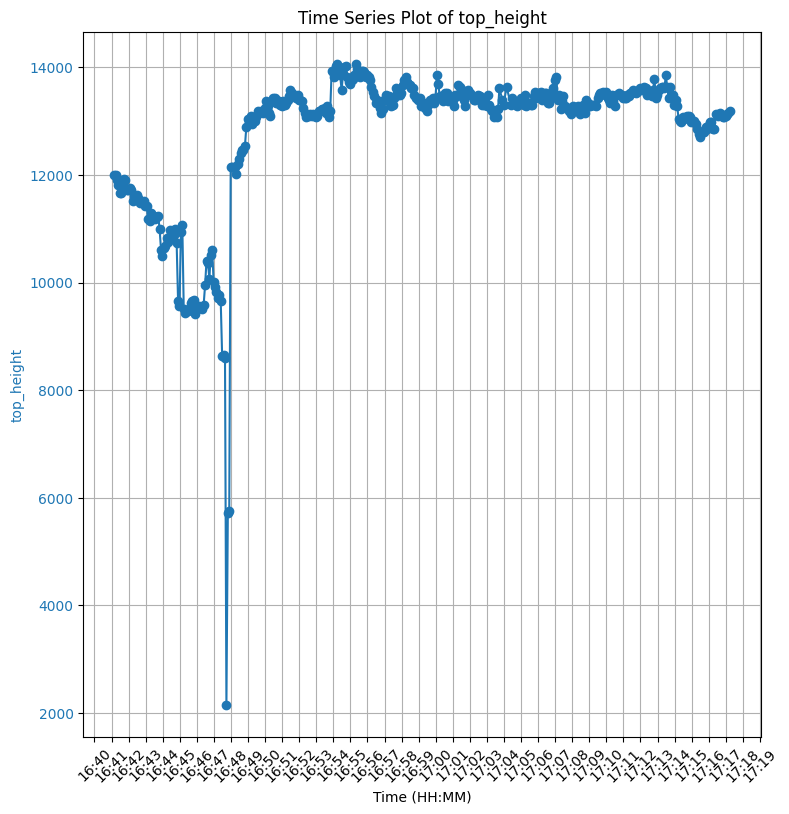

In [ ]:
df_filtered['full_timestamp'] = pd.to_datetime(df_filtered['date'] + ' ' + df_filtered['timestamp'])
plot_time_series(df_filtered, 'full_timestamp', 'top_height')

In [ ]:
df_dropped.head()
df_filtered.shape

(423, 13)

In [ ]:
df_filtered.to_csv('lidar_processed_170512_164101_171715.csv', index=False)
df_dropped['full_timestamp'] = pd.to_datetime(df_dropped['date'] + ' ' + df_dropped['timestamp'])
df_dropped.to_csv('lidar_dropped_170512_164101_171715.csv', index=False)

<ipython-input-13-0628b25e67e8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropped['full_timestamp'] = pd.to_datetime(df_dropped['date'] + ' ' + df_dropped['timestamp'])


In [5]:
!pwd

/content/drive/MyDrive/harvard.dce.nasa.cloud2cloud


In [6]:
# read csv file to pandas df
df = pd.read_csv('lidar_processed/goesrplt_CPL_layers_17935_20170514_processed.txt')
df.head()

,date,timestamp,lat,lon,alt,angle,N,GH,top_height,bottom_height,layer_discriminator,angle_diff_to_prev
0,2017-05-14,11:48:46,30.6469,-82.2602,17388,0.86,1,-999,1229,809,3,-0.11
1,2017-05-14,11:48:51,30.6391,-82.2540,17418,0.73,1,-999,1169,809,3,-0.13
2,2017-05-14,11:48:56,30.6312,-82.2477,17418,0.70,1,-999,1079,779,3,-0.03
3,2017-05-14,11:49:01,30.6233,-82.2414,17448,0.56,1,-999,1169,779,3,-0.14
4,2017-05-14,11:49:06,30.6154,-82.2351,17448,0.27,3,-999,1019,750,3,-0.29


In [7]:
df.tail()

,date,timestamp,lat,lon,alt,angle,N,GH,top_height,bottom_height,layer_discriminator,angle_diff_to_prev
3769,2017-05-14,18:30:34,30.6055,-82.2519,19786,0.30,1,-999,2638,2189,3,-0.04
3770,2017-05-14,18:30:39,30.6136,-82.2571,19786,0.32,1,60,2548,2219,3,0.02
3771,2017-05-14,18:30:49,30.6300,-82.2677,19786,0.30,1,60,2099,1169,3,-0.02
3772,2017-05-14,18:30:54,30.6382,-82.2729,19786,0.34,2,60,2219,1889,3,0.04
3773,2017-05-14,18:30:59,30.6463,-82.2782,19786,0.31,1,60,2249,1979,3,-0.03
